In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import holidays

import statsmodels.api as sm
from statsmodels.tsa.seasonal import MSTL, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.base import ForecastingHorizon

from data_prepro import get_energy_data_today

In [2]:
df_energy = get_energy_data_today(to_date="20231201")
print(df_energy.info())
df_energy.tail(5)

C:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\VL - PTSFC\2023_11-PTSFC
0 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78168 entries, 2014-12-31 23:00:00+00:00 to 2023-12-01 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78168 non-null  datetime64[ns, CET]
 1   gesamt         78168 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
None


,timestamp_CET,gesamt
timestamp_UTC,,
2023-12-01 18:00:00+00:00,2023-12-01 19:00:00+01:00,65481.75
2023-12-01 19:00:00+00:00,2023-12-01 20:00:00+01:00,61924.25
2023-12-01 20:00:00+00:00,2023-12-01 21:00:00+01:00,58844.75
2023-12-01 21:00:00+00:00,2023-12-01 22:00:00+01:00,56488.50
2023-12-01 22:00:00+00:00,2023-12-01 23:00:00+01:00,53533.75


### Exploratory Analysis

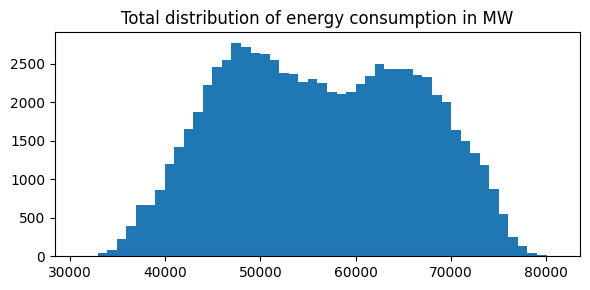

In [3]:
# plot distribution of "gesamt" column

plt.figure(figsize=(6, 3))

plt.hist(df_energy["gesamt"], bins=50)
plt.title("Total distribution of energy consumption in MW")

plt.tight_layout()
plt.show()

In [4]:
# print some descriptive stats of df_energy["gesamt"]
df_energy["gesamt"].describe()

count    78168.000000
mean     56366.804364
std      10002.910488
min      30909.000000
25%      48131.250000
50%      56064.875000
75%      64687.062500
max      81077.500000
Name: gesamt, dtype: float64

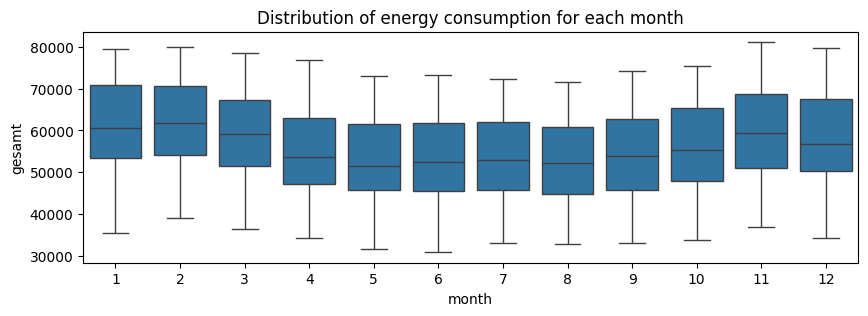

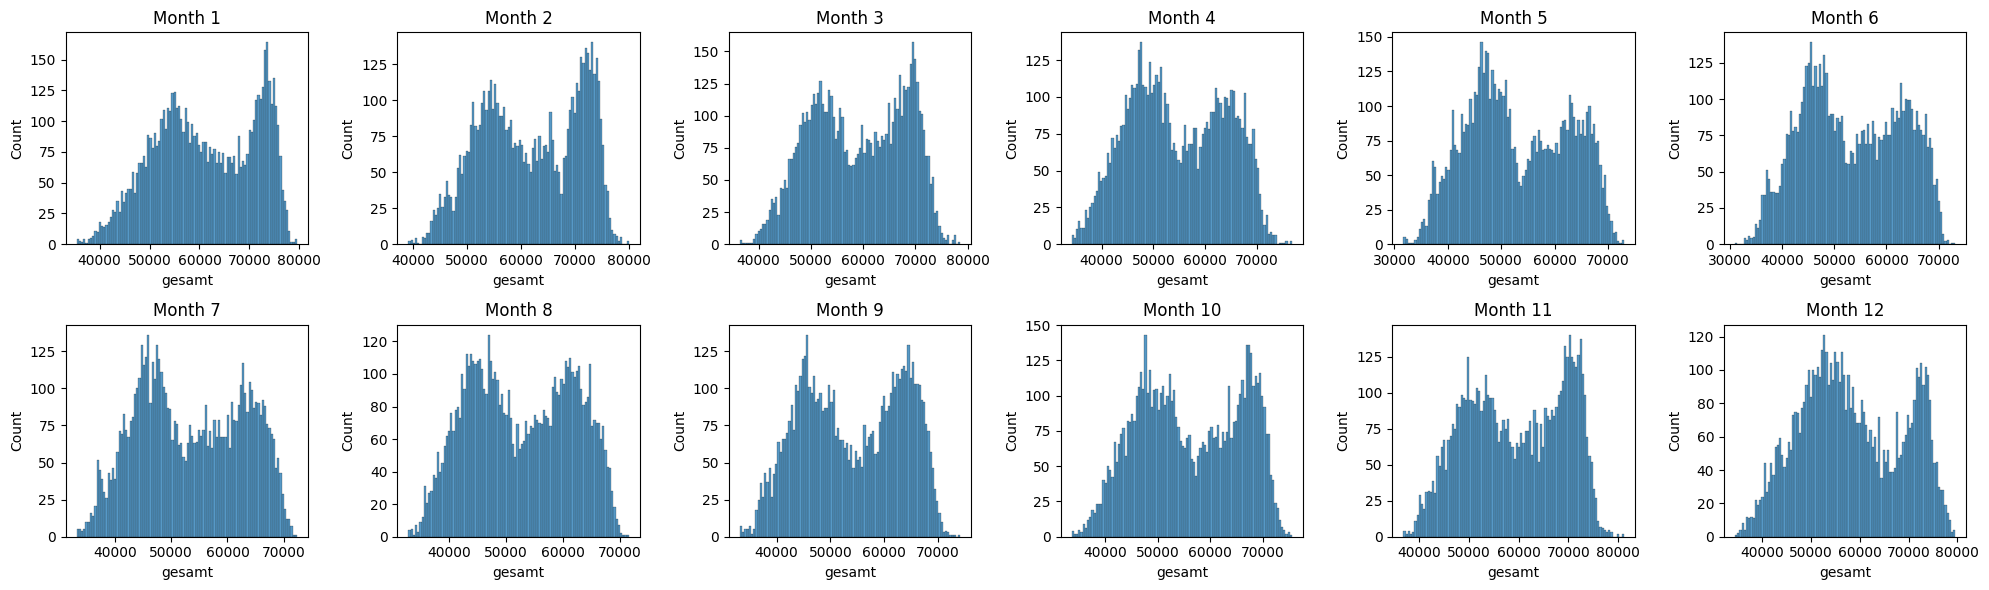

In [5]:
# plot distribution of "gesamt" column for each month

plt.figure(figsize=(10, 3))
sns.boxplot(x=df_energy['timestamp_CET'].dt.month, y=df_energy['gesamt'])
plt.xlabel('month')
plt.ylabel('gesamt')
plt.title('Distribution of energy consumption for each month')
plt.show()

# do it again in separate histogram plots

plt.figure(figsize=(20, 6))
for i, m_idx in enumerate(range(1,13)):
    plt.subplot(2, 6, i + 1)
    sns.histplot(df_energy[df_energy['timestamp_CET'].dt.month == m_idx]['gesamt'], bins=100)
    plt.title(f'Month {m_idx}')
plt.tight_layout()
plt.show()


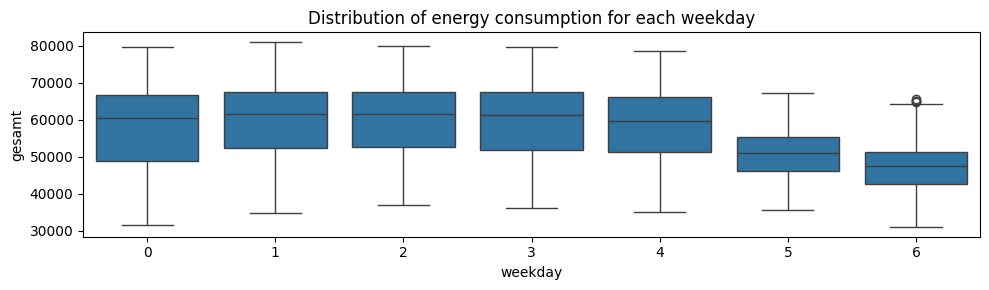

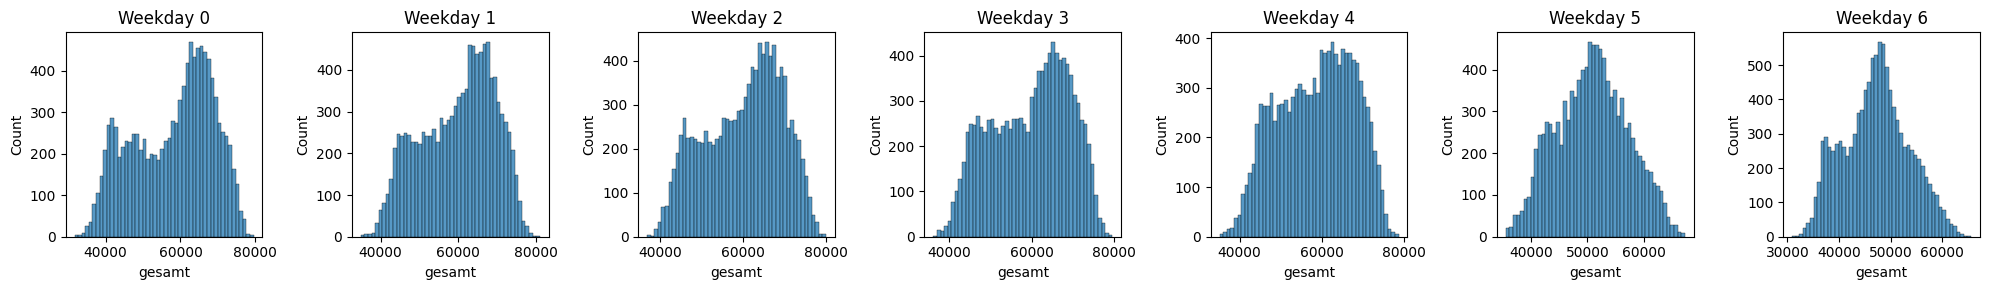

In [6]:
# plot distribution of "gesamt" column for each weekday

plt.figure(figsize=(10, 3))
sns.boxplot(x=df_energy['timestamp_CET'].dt.weekday, y=df_energy['gesamt'])
plt.xlabel('weekday')
plt.ylabel('gesamt')
plt.title('Distribution of energy consumption for each weekday')
plt.tight_layout()
plt.show()

# do it again in separate histogram plots

plt.figure(figsize=(20, 3))
for i, day in enumerate(range(7)):
    plt.subplot(1, 7, i + 1)
    sns.histplot(df_energy[df_energy['timestamp_CET'].dt.weekday == day]['gesamt'], bins=50)
    plt.title(f'Weekday {day}')
plt.tight_layout()
plt.show()


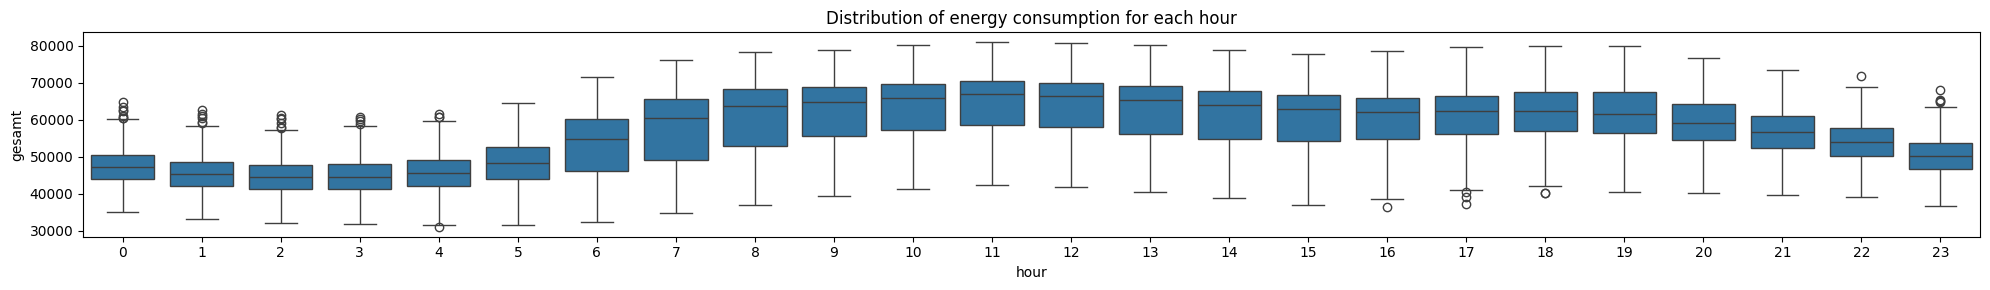

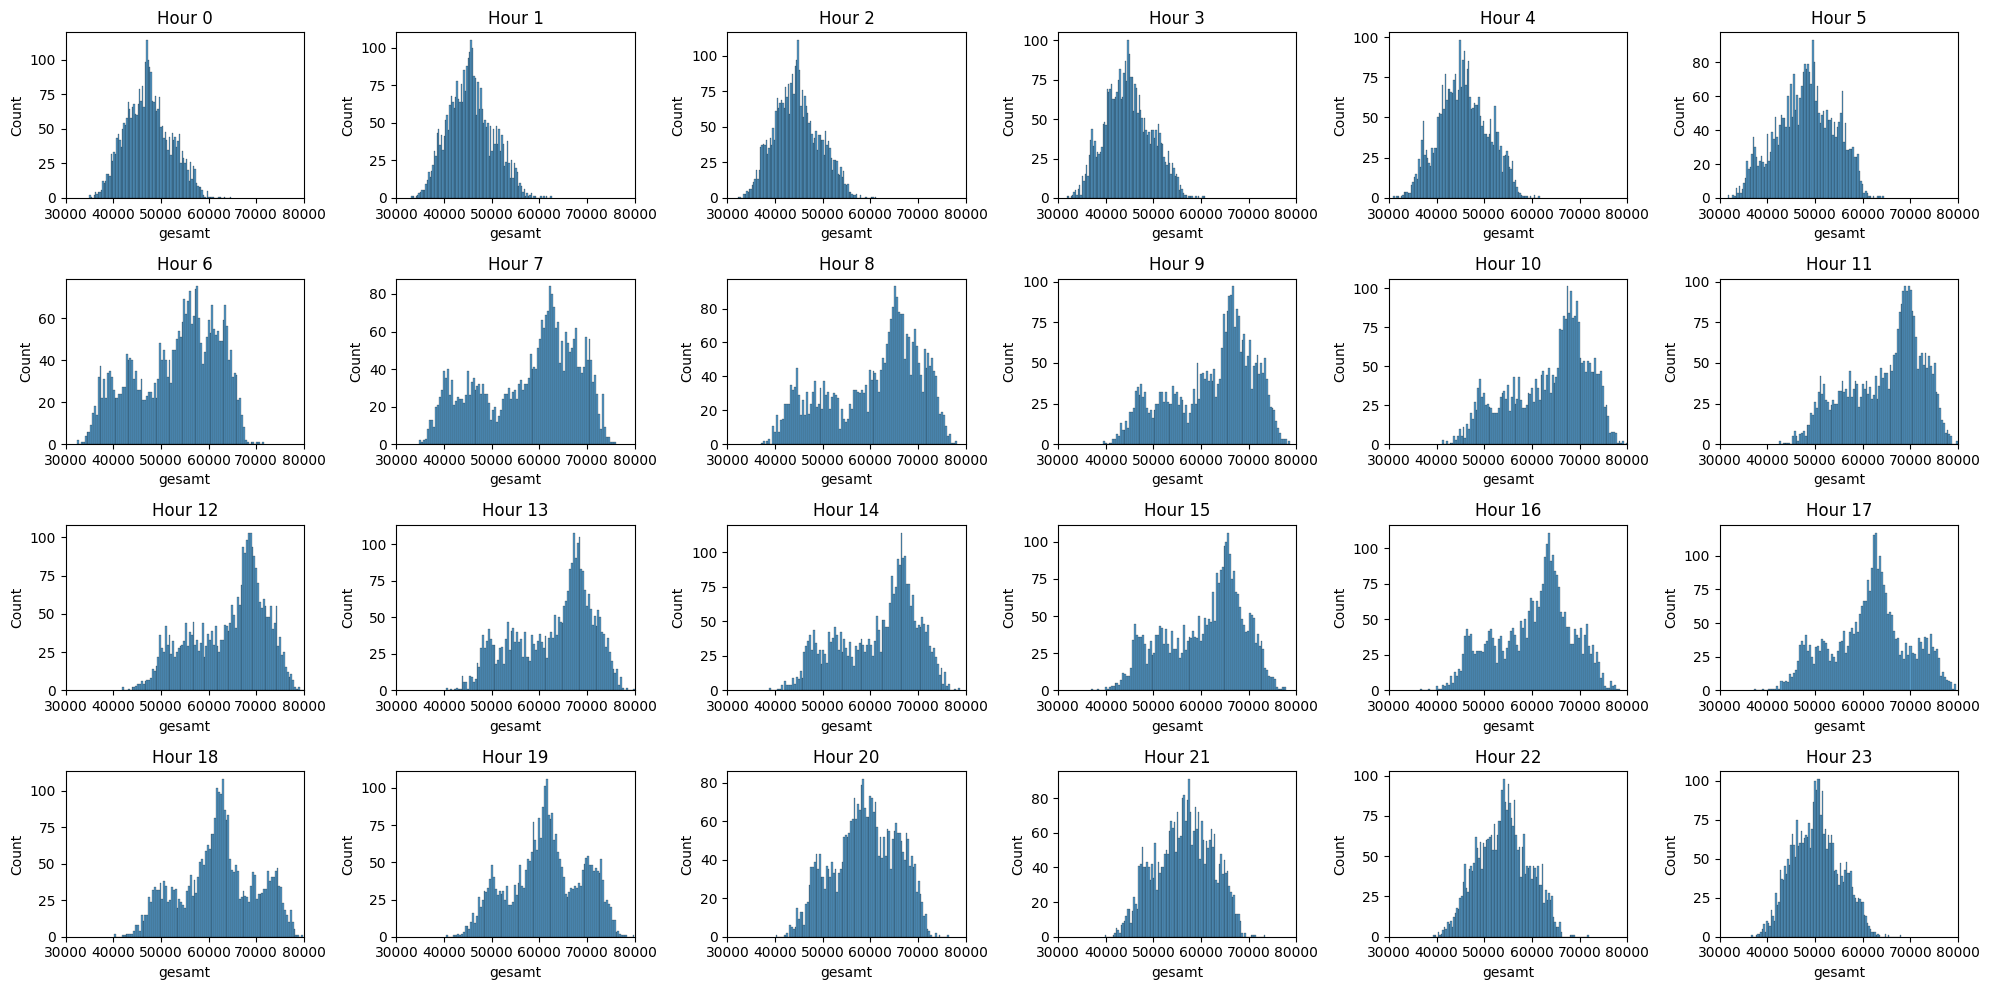

In [7]:
# plot distribution of "gesamt" column for each hour

plt.figure(figsize=(20, 3))
sns.boxplot(x=df_energy['timestamp_CET'].dt.hour, y=df_energy['gesamt'])
plt.xlabel('hour')
plt.ylabel('gesamt')
plt.title('Distribution of energy consumption for each hour')
plt.tight_layout()
plt.show()

# do it again in separate histogram plots

plt.figure(figsize=(20, 10))
for i, hr in enumerate(range(24)):
    plt.subplot(4, 6, i + 1)
    sns.histplot(df_energy[df_energy['timestamp_CET'].dt.hour == hr]['gesamt'], bins=100)
    # fix x axis from 30_000 to 80_000
    plt.xlim(30_000, 80_000)
    plt.title(f'Hour {hr}')
plt.tight_layout()
plt.show()


In [11]:
# # plot distribution of "gesamt" column for each hour and weekday

# weekday_mapping = {0: 'Monday', 
#                    1: 'Tuesday', 
#                    2: 'Wednesday', 
#                    3: 'Thursday', 
#                    4: 'Friday', 
#                    5: 'Saturday', 
#                    6: 'Sunday'}

# for day in range(7):

#     # turn integer weekday to name ie 0 to monday
#     weekday_name = weekday_mapping.get(day, 'Invalid Index')

#     df_day = df_energy[(df_energy['timestamp_CET'].dt.weekday == day)]
    
#     plt.figure(figsize=(20, 13))

#     # make this plot on top
#     ax1 = plt.subplot(5,6,(1,6))
#     sns.boxplot(x=df_day['timestamp_CET'].dt.hour, y=df_energy['gesamt'], ax=ax1)
#     ax1.set_xlabel('hour')
#     ax1.set_ylabel('gesamt')
#     ax1.set_ylim(30_000, 80_000)
#     ax1.set_title(f'{weekday_name} - hourly distribution of energy load')

#     # put this plot below
#     for i, hr in enumerate(range(24)):
#         ax2 = plt.subplot(5, 6, i + 7)
#         sns.histplot(df_day[df_day['timestamp_CET'].dt.hour == hr]['gesamt'], bins=50, ax=ax2)
#         # set axis x lims
#         ax2.set_xlim(30_000, 80_000)
#         ax2.set_ylim(0, 50)
#         # remove axis labels
#         ax2.set_xlabel('')
#         ax2.set_ylabel('')
#         ax2.set_title(f'hour {hr}')

#     plt.tight_layout()
#     plt.savefig(f'weekday_{day+1} hourly distribution hist plot.png')
#     # plt.show()
#     print(f'weekday_{day+1} done!')
#     plt.close()


In [10]:
# # plot distribution of "gesamt" column for each hour and weekday in summer & winter

# summer_months = [4, 5, 6, 7, 8, 9]
# winter_months = [10, 11, 12, 1, 2, 3] # heating starts in beginning of october

# for season in ['summer', 'winter']:

#     for day in range(7):

#         # turn integer weekday to name ie 0 to monday
#         weekday_name = weekday_mapping.get(day, 'Invalid Index')

#         if season == 'summer' :
#             df_day = df_energy[(df_energy['timestamp_CET'].dt.weekday == day) & 
#                                (df_energy['timestamp_CET'].dt.month.isin(summer_months))]
#         elif season == 'winter' :
#             df_day = df_energy[(df_energy['timestamp_CET'].dt.weekday == day) & 
#                                (df_energy['timestamp_CET'].dt.month.isin(winter_months))]

#         plt.figure(figsize=(20, 13))

#         # make this plot on top
#         ax1 = plt.subplot(5,6,(1,6))
#         sns.boxplot(x=df_day['timestamp_CET'].dt.hour, y=df_energy['gesamt'], ax=ax1)
#         ax1.set_xlabel('hour')
#         ax1.set_ylabel('gesamt')
#         ax1.set_ylim(30_000, 80_000)
#         ax1.set_title(f'{weekday_name} {season} - hourly distribution of energy load')

#         # put this plot below
#         for i, hr in enumerate(range(24)):
#             ax2 = plt.subplot(5, 6, i + 7)
#             sns.histplot(df_day[df_day['timestamp_CET'].dt.hour == hr]['gesamt'], bins=50, ax=ax2)
#             # set axis x lims
#             ax2.set_xlim(30_000, 80_000)
#             ax2.set_ylim(0, 25)
#             # remove labels
#             ax2.set_xlabel('')
#             ax2.set_ylabel('')
#             ax2.set_title(f'hour {hr}')

#         plt.tight_layout()
#         plt.savefig(f'weekday_{day+1} {season} hourly distribution hist plot.png')
#         # plt.show()

#         print(f'weekday_{day+1} done!')
#         plt.close()

### Add Dummy Vars

In [35]:
df_energy_dummy = df_energy.copy()

# binary dummy var for each month
dummy_month = pd.get_dummies(df_energy['timestamp_CET'].dt.month, prefix='month').astype(int)
# leave out first month to avoid multicollinearity
dummy_month = dummy_month.iloc[:, 1:]

# binary dummy var for each weekday
dummy_weekday = pd.get_dummies(df_energy['timestamp_CET'].dt.weekday, prefix='weekday').astype(int)
# leave out first weekday to avoid multicollinearity
dummy_weekday = dummy_weekday.iloc[:, 1:]

# binary dummy var for each hour
dummy_hour = pd.get_dummies(df_energy['timestamp_CET'].dt.hour, prefix='hour').astype(int)
# leave out first hour to avoid multicollinearity
dummy_hour = dummy_hour.iloc[:, 1:]

# binary dummy var for weekend
# dummy_weekend = df_energy['timestamp_CET'].dt.weekday.isin([5,6]).rename('is_weekend').astype(int)
# binary dummy var for night
# dummy_night = df_energy['timestamp_CET'].dt.hour.isin([22,23,0,1,2,3]).rename('is_night').astype(int)
# binary dummy var for summer vs winter
# summer_months = [4, 5, 6, 7, 8, 9]
# dummy_season = df_energy['timestamp_CET'].dt.month.isin(summer_months).rename('is_summer').astype(int)

# concat all dummies
df_energy_dummy = pd.concat([df_energy_dummy, dummy_month, dummy_weekday, dummy_hour], axis=1)
df_energy_dummy.tail(5)

,timestamp_CET,gesamt,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
timestamp_UTC,,,,,,,,,,,,,,,,,,,,,
2023-12-01 18:00:00+00:00,2023-12-01 19:00:00+01:00,65481.75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2023-12-01 19:00:00+00:00,2023-12-01 20:00:00+01:00,61924.25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2023-12-01 20:00:00+00:00,2023-12-01 21:00:00+01:00,58844.75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2023-12-01 21:00:00+00:00,2023-12-01 22:00:00+01:00,56488.50,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2023-12-01 22:00:00+00:00,2023-12-01 23:00:00+01:00,53533.75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [36]:
# = = = = = = = = = = = = 
# create holiday dummies

# get all years in dataframe
uniq_yrs = df_energy['timestamp_CET'].dt.year.unique()
# print(uniq_yrs)

# get holidays for germany
holidays_de = holidays.DE(years=uniq_yrs)
# print(holidays_de)

# Karfreitag
karfreitag_dates = [k for k, v in holidays_de.items() if v == 'Karfreitag']
df_energy_dummy['is_holiday_karfreitag'] = df_energy_dummy['timestamp_CET'].dt.date.isin(karfreitag_dates).astype(int)

# Easter = get all dates in holidays_de dict where the value is 'Ostermontag'
easter_dates = [k for k, v in holidays_de.items() if v == 'Ostermontag']
df_energy_dummy['is_holiday_easter'] = df_energy_dummy['timestamp_CET'].dt.date.isin(easter_dates).astype(int)

# Erster Mai
erstermai_dates = [k for k, v in holidays_de.items() if v == 'Erster Mai']
df_energy_dummy['is_holiday_erstermai'] = df_energy_dummy['timestamp_CET'].dt.date.isin(erstermai_dates).astype(int)

# Christi Himmelfahrt
himmelfahrt_dates = [k for k, v in holidays_de.items() if v == 'Christi Himmelfahrt']
df_energy_dummy['is_holiday_himmelfahrt'] = df_energy_dummy['timestamp_CET'].dt.date.isin(himmelfahrt_dates).astype(int)

# Pfingstmontag
pfingstmontag_dates = [k for k, v in holidays_de.items() if v == 'Pfingstmontag']
df_energy_dummy['is_holiday_pfingstmontag'] = df_energy_dummy['timestamp_CET'].dt.date.isin(pfingstmontag_dates).astype(int)

# Tag der Deutschen Einheit
einheit_dates = [k for k, v in holidays_de.items() if v == 'Tag der Deutschen Einheit']
df_energy_dummy['is_holiday_einheit'] = df_energy_dummy['timestamp_CET'].dt.date.isin(einheit_dates).astype(int)

# christmas = list of datetimes from 12.24 to 12.26 
df_energy_dummy['is_holiday_xmas_d23'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 23)).astype(int)
df_energy_dummy['is_holiday_xmas_d24'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 24)).astype(int)
df_energy_dummy['is_holiday_xmas_d25'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 25)).astype(int)
df_energy_dummy['is_holiday_xmas_d26'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 26)).astype(int)

# brückentage zwischen weihnachten und neujahr
# 12.27, 12.28, 12.29, 12.30
df_energy_dummy['is_holiday_xmas2newyear'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day.isin([27,28,29,30]))).astype(int)

# newyears + silvester ist kein feiertag aber die meisten nehmen trotzdem frei
# create dummy variable for all rows where timestamp_CET is 12.31 or 01.01
df_energy_dummy['is_holiday_newyear_d31'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 31)).astype(int)
df_energy_dummy['is_holiday_newyear_d01'] = ((df_energy_dummy['timestamp_CET'].dt.month == 1) & (df_energy_dummy['timestamp_CET'].dt.day == 1)).astype(int)

# check if date is holiday
# df_energy_dummy['is_holiday'] = df_energy_dummy['timestamp_CET'].dt.date.isin(holiday_dates_de).astype(int)

df_energy_dummy.tail(5)

,timestamp_CET,gesamt,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,is_holiday_erstermai,is_holiday_himmelfahrt,is_holiday_pfingstmontag,is_holiday_einheit,is_holiday_xmas_d1,is_holiday_xmas_d2,is_holiday_xmas_d3,is_holiday_xmas2newyear,is_holiday_newyear_d1,is_holiday_newyear_d2
timestamp_UTC,,,,,,,,,,,,,,,,,,,,,
2023-12-01 18:00:00+00:00,2023-12-01 19:00:00+01:00,65481.75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-01 19:00:00+00:00,2023-12-01 20:00:00+01:00,61924.25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-01 20:00:00+00:00,2023-12-01 21:00:00+01:00,58844.75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-01 21:00:00+00:00,2023-12-01 22:00:00+01:00,56488.50,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-01 22:00:00+00:00,2023-12-01 23:00:00+01:00,53533.75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


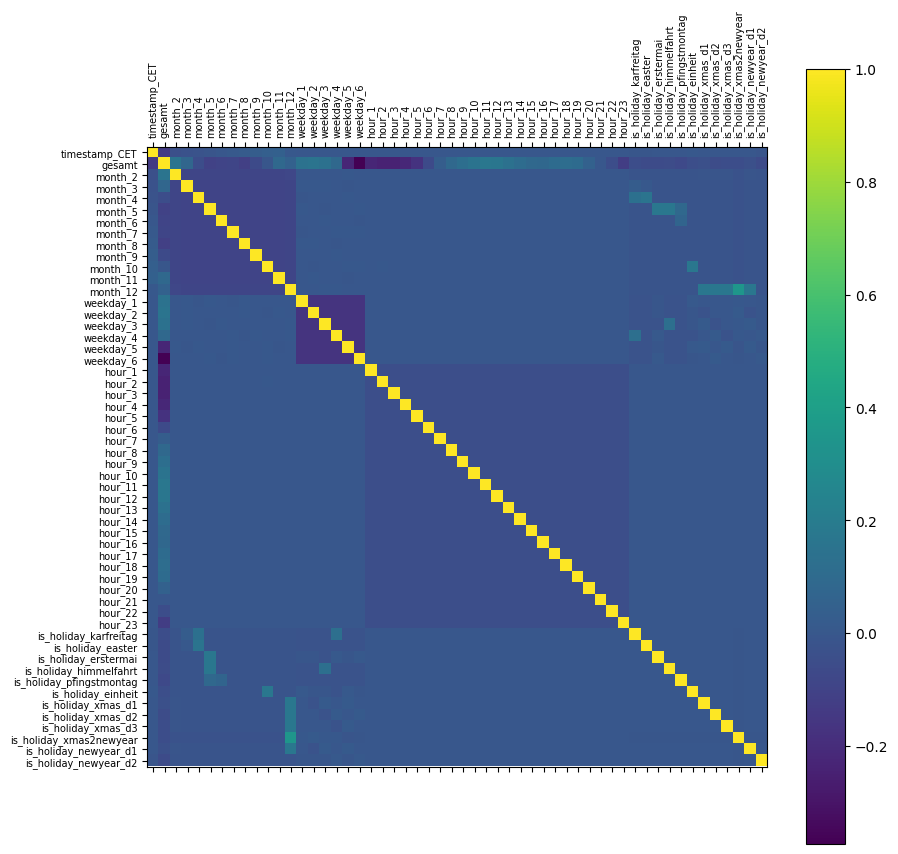

In [37]:
# check correlation between variables in df to avoid multicollinearity
# print(df_energy_dummy.dtypes)

# in a plot and highlight high correlations
fig = plt.figure(figsize=(10,10))
plt.matshow(df_energy_dummy.corr(), fignum=fig.number)

# add colorbar
plt.colorbar()

# add labels, rotate label text
plt.xticks(range(df_energy_dummy.shape[1]), df_energy_dummy.columns, rotation=90)
plt.yticks(range(df_energy_dummy.shape[1]), df_energy_dummy.columns)
# make label text small
plt.tick_params(labelsize=7)

plt.show()

### Fit Linear Model

In [44]:
def fit_lin_reg(df, method='ols', test_perc=0.01, drop_cols=None):

    if drop_cols is None:
        drop_cols = ['timestamp_CET']
    else:
        drop_cols.append('timestamp_CET')

    # drop columns
    df = df.drop(drop_cols, axis=1)

    # do train test split manually
    n_total = df.shape[0]
    n_train = int((1-test_perc) * n_total)
    n_test = n_total - n_train

    X_train = df.iloc[:n_train]
    X_test = df.iloc[-n_test:]

    y_train = X_train['gesamt']
    y_test = X_test['gesamt']

    X_train = X_train.drop(['gesamt'], axis=1)
    X_test = X_test.drop(['gesamt'], axis=1)

    # Add a constant term to the features matrix for statsmodels
    X_train = sm.add_constant(X_train)
    # Create model using OLS (Ordinary Least Squares)
    model = sm.OLS(y_train, X_train)

    if method == 'ols' :

        results = model.fit()
        print(results.summary())

    elif method == 'ridge' :

        results = model.fit_regularized(method = 'elastic_net')
        print(results.params)
        # how to get r squared ???

    # Add a constant term to the features matrix for the test set
    X_test = sm.add_constant(X_test)
    # Make predictions
    y_pred = results.predict(X_test)
    # Print RMSE
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

    # Plot in-sample predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_test, label='test')
    plt.plot(y_test.index, y_pred, label='predicted')
    plt.legend()
    plt.show()


                            OLS Regression Results                            
Dep. Variable:                 gesamt   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     6591.
Date:                Thu, 21 Dec 2023   Prob (F-statistic):               0.00
Time:                        15:33:39   Log-Likelihood:            -4.1421e+05
No. Observations:               43385   AIC:                         8.285e+05
Df Residuals:                   43332   BIC:                         8.290e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

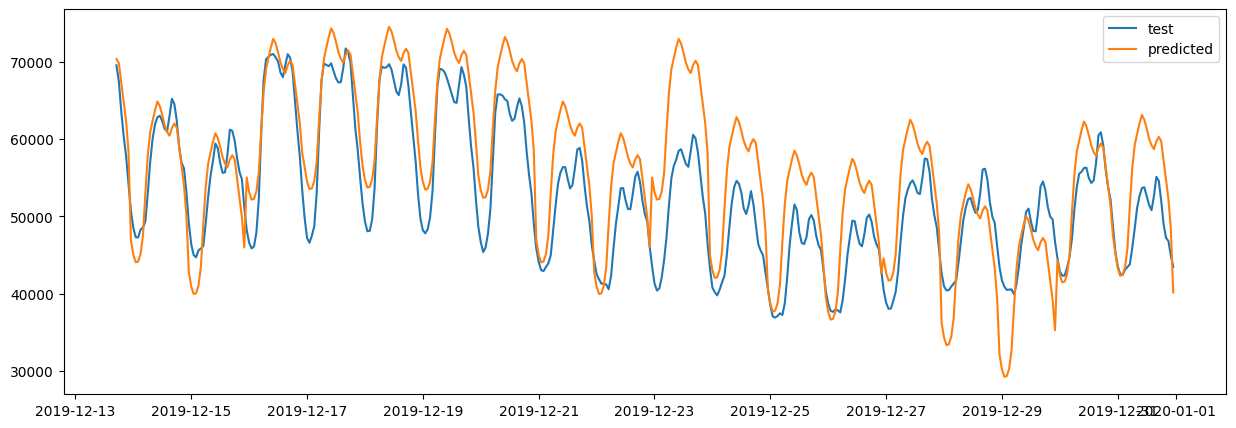

const                       54766.610125
month_2                        66.318570
month_3                     -2399.970177
month_4                     -6031.098046
month_5                     -7257.765878
month_6                     -7526.829714
month_7                     -7358.576043
month_8                     -8419.705671
month_9                     -6906.607242
month_10                    -4820.617927
month_11                    -1771.761502
month_12                     -231.290437
weekday_1                    1443.108781
weekday_2                    1647.453823
weekday_3                    1385.573275
weekday_4                     316.018949
weekday_5                   -8019.702219
weekday_6                  -12123.995877
hour_1                      -1459.081505
hour_2                      -2431.260438
hour_3                      -2332.637229
hour_4                      -1362.527025
hour_5                       1077.177898
hour_6                       6585.748833
hour_7          

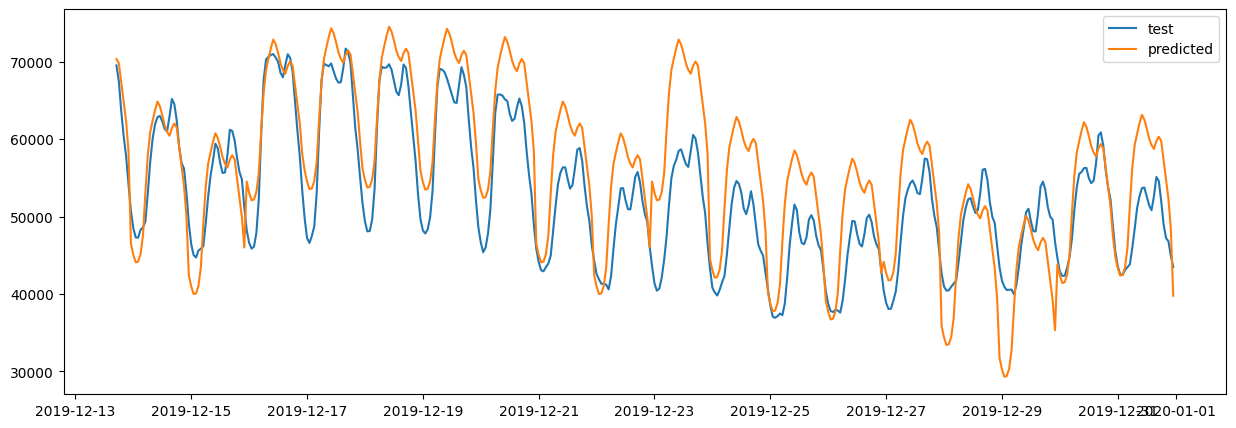

In [52]:
# take smaller dataset
df_energy_dummy_small = df_energy_dummy.loc[(df_energy_dummy['timestamp_CET'] > '2015-01-01') & 
                                            (df_energy_dummy['timestamp_CET'] <= '2020-01-01')]

# fit model on all data and another fit without "is_weekend" and "is_night"
fit_lin_reg(df_energy_dummy_small, method='ols')
fit_lin_reg(df_energy_dummy_small, method='ridge')

In [298]:
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming df_energy_dummy_small is your DataFrame
# Replace 'your_target_column' with the actual name of your target column
target_column = 'gesamt'

# Select features and target variable
features = df_energy_dummy_small.drop([target_column, 'timestamp_CET'], axis=1)
target = df_energy_dummy_small[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.01, random_state=42)

# Fit Kernel Regression
kr = KernelReg(y_train, X_train, var_type='c' * X_train.shape[1])
y_pred, _ = kr.fit()

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: ", rmse)

# Plot predictions vs. actual values
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()


In [7]:
# take last n values only
n_last = 24*365
df_energy_small = df_energy.iloc[-n_last:][['gesamt']]

# take values from 2020-01-01 to 2023-01-01
# df_energy_small = df_energy.loc['2020-01-01':'2023-01-01'][['gesamt']]
df_energy_small.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2020-12-20 14:00:00+00:00 to 2023-12-20 13:00:00+00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gesamt  26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB


### MSTL

In [ ]:

mstl = MSTL(df_energy_small, periods=[24, 24*7], iterate=1, 
            stl_kwargs={"seasonal_deg": 0,
                        "inner_iter": 2,
                        "outer_iter": 0})

res = mstl.fit()

plt.rc("figure", figsize=(15, 10))
plt.rc("font", size=10)

res.plot()
plt.tight_layout()
plt.show()

### TBATS

In [11]:
from tbats import TBATS
# use original tbtas library as sktime adapter has problems with returning fitted params ...

# take last n values only
n_last = int(24*365 / 4)
df_energy_small = df_energy.iloc[-n_last:][['gesamt']]

# = = = = = = = = = = = = = 
# Train Test Split

y = df_energy_small['gesamt']
test_perc = 0.1
test_size = np.floor(len(y)*test_perc).astype(int)
y_train, y_test = temporal_train_test_split(y, test_size=test_size)

# = = = = = = = = = = = = = 
# TBATS Forecasting Model

forecaster = TBATS(
    use_box_cox=False,
    use_trend=True,
    use_damped_trend=True,
    seasonal_periods=[24],
    use_arma_errors=False,
    n_jobs=1)

print('start fitting ...')
fitted_model = forecaster.fit(y_train)
print(fitted_model.summary())

start fitting ...
Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [24.]
Seasonal harmonics [10]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 1.450052
Trend (Beta): 0.136602
Damping Parameter (Phi): 0.800000
Seasonal Parameters (Gamma): [-2.56441101e-07 -4.71684126e-07]
AR coefficients []
MA coefficients []
Seed vector [ 5.01811678e+04 -5.39300868e+02  3.87624333e+03  2.99641178e+03
  6.11027985e+02 -6.88076010e+02 -1.66035098e+02 -2.07825438e+01
 -4.93380963e+01  4.44871118e+01  1.46901776e+01 -1.55386761e+01
  8.15955290e+03 -1.87299300e+03  2.49426370e+02 -1.16693516e+02
 -1.68525518e+02  2.20896565e+02  2.79184130e+01 -4.59239498e+01
 -2.19272653e+01  2.03855332e+01]

AIC 42162.014417


In [ ]:
y_pred, confidence_info = fitted_model.forecast(steps=test_size, confidence_level=0.95)

In [44]:
# fitted_model.plot()
# [TODO] look for same functionality as in tbats fnct in R forecast package to plot decomposition
# doesnt seem to have a plot function ...
# GOAL = want to verify ... is MSTL the same as TBATS given the same parameters ???

In [40]:
# Time series analysis
# print(fitted_model.y_hat) # in sample prediction
# print(fitted_model.resid) # in sample residuals
# print(fitted_model.aic)

# Reading model parameters
# print(fitted_model.params.alpha)
# print(fitted_model.params.beta)
# print(fitted_model.params.x0)
# print(fitted_model.params.components.use_box_cox)
# print(fitted_model.params.components.seasonal_harmonics)

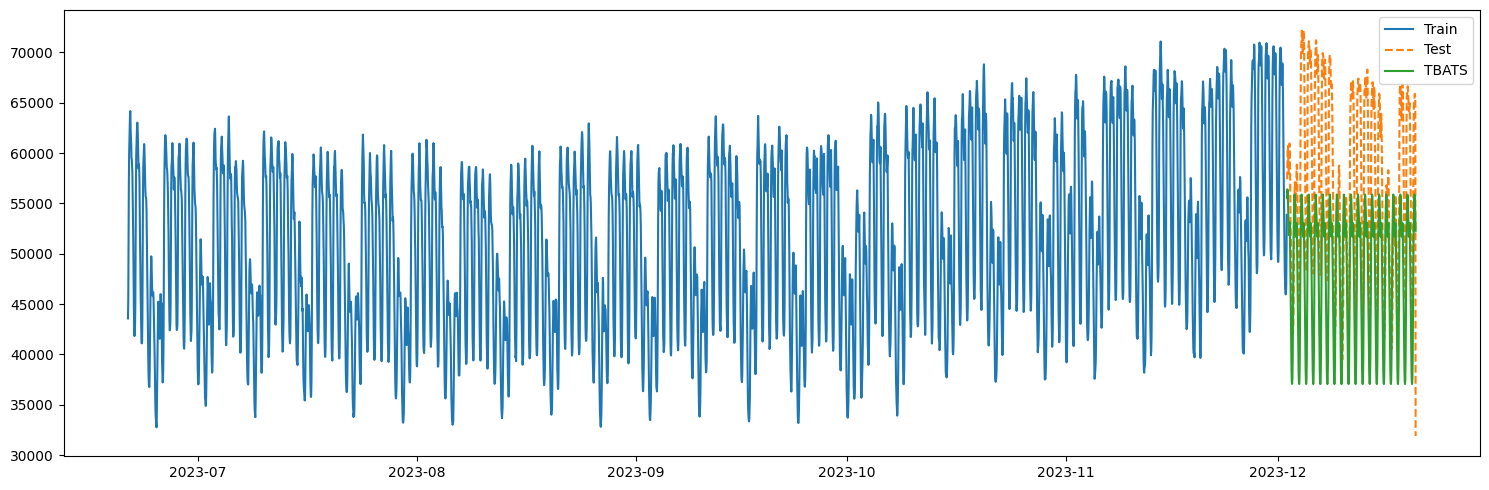

In [10]:
plt.figure(figsize=(15, 5))

plt.plot(y_train, label='Train')
plt.plot(y_test, ls='--', label='Test')
plt.plot(y_test.index, y_pred, label='TBATS')

# shift index back by 1 year
# last_yr_idx = df_energy_small.index - pd.DateOffset(years=1)
# plt.plot(df_energy[last_yr_idx].values, label='Last Year')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# get national holidays in germany
# make dummy variables in dataframe for each holiday
# regress on dummy variables and seasonal components as described in De Livera, Hyndman, Snyder paper
# obtain estimated effect of holidays which we can now remove from the series
# do one more MSTL on the series without holiday effects

In [ ]:
import holidays
bw_holidays = holidays.DE(prov='BW')

### FCAST based on Thursday 00:00

In [8]:
# get date of next thursday 00:00 based on todays date
today = datetime.today()
next_thursday = today + pd.DateOffset(days=(3-today.weekday())%7)
next_thursday = next_thursday.replace(hour=0, minute=0, second=0, microsecond=0)
print(next_thursday)

# get fcast index
# fcast index = starting from thursday 00:00 of the week until 36, 40, 44 and 60, 64, 68 hours ahead
fcast_idx = next_thursday + pd.to_timedelta([36, 40, 44, 60, 64, 68], unit='h')
fcast_idx

2023-12-21 00:00:00


DatetimeIndex(['2023-12-22 12:00:00', '2023-12-22 16:00:00',
               '2023-12-22 20:00:00', '2023-12-23 12:00:00',
               '2023-12-23 16:00:00', '2023-12-23 20:00:00'],
              dtype='datetime64[ns]', freq=None)

'2023-12-20'